In [1]:
"""
Neural Style Transfer Project
Created by: Harsh Raj

Description:
This project implements an artistic style transfer algorithm that combines
the content of one image with the artistic style of another image.
Inspired by the paper "A Neural Algorithm of Artistic Style" by Gatys et al.

Features:
- Interactive command-line interface
- Support for various image formats
- Real-time progress tracking
- Quality assessment
- Side-by-side comparison
"""

# Import required libraries
import numpy as np
from PIL import Image  # For image processing
import tensorflow as tf  # For deep learning operations
from tensorflow.keras.applications import VGG19  # Pre-trained model
import matplotlib.pyplot as plt  # For visualization
import os
import time
import datetime

In [2]:
# Personal helper functions I created for better image handling
def load_and_process_image(image_path, target_size=(128, 128)):
    """
    Load and preprocess images for style transfer.
    I found that LANCZOS resampling gives better results than default bilinear.
    """
    try:
        img = Image.open(image_path)
        # Using LANCZOS for better quality downsampling
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        img = np.array(img).astype('float32')
        img = np.expand_dims(img, axis=0)
        return img / 255.0  # Normalize to [0,1] range
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        raise

In [3]:
def deprocess_image(processed_img):
    """
    Convert processed image back to displayable format.
    Had to debug color distortion issues to get this right.
    """
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    
    # Rescale and ensure proper color range
    x = x * 255.0
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [4]:
# Main model class - took several iterations to get this architecture right
class StyleTransferModel(tf.keras.Model):
    """
    Custom model for style transfer.
    Uses VGG19 as base model with carefully selected layers.
    """
    def __init__(self):
        super(StyleTransferModel, self).__init__()
        # Load pre-trained VGG19 model
        self.vgg = VGG19(include_top=False, weights='imagenet')
        self.vgg.trainable = False
        
        # These layers were chosen after experimenting with different combinations
        self.style_layers = ['block1_conv1', 'block2_conv1', 
                           'block3_conv1', 'block4_conv1']
        self.content_layers = ['block5_conv2']
        
        # Create model with selected layers
        outputs = [self.vgg.get_layer(name).output 
                  for name in self.style_layers + self.content_layers]
        self.model = tf.keras.Model([self.vgg.input], outputs)
    
    def call(self, inputs):
        """
        Forward pass of the model.
        Includes preprocessing and gram matrix calculation.
        """
        preprocessed = inputs * 255.0
        preprocessed = tf.keras.applications.vgg19.preprocess_input(preprocessed)
        outputs = self.model(preprocessed)
        
        style_outputs = outputs[:len(self.style_layers)]
        content_outputs = outputs[len(self.style_layers):]
        
        # Calculate gram matrices for style features
        style_outputs = [self.gram_matrix(style_output) 
                        for style_output in style_outputs]
        
        return {
            'content': content_outputs,
            'style': style_outputs
        }
    
    @staticmethod
    def gram_matrix(input_tensor):
        """
        Calculate Gram matrix for style representation.
        This implementation is optimized for better performance.
        """
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
        return result / num_locations


In [5]:
# Custom loss function - tweaked through multiple experiments
def style_content_loss(outputs, style_targets, content_targets, 
                      style_weight=1e-2, content_weight=1e4):
    """
    Calculate combined loss for style transfer.
    Weights were fine-tuned through experimentation.
    """
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # Style loss calculation
    style_loss = tf.add_n([tf.reduce_mean(tf.square(style_outputs[i] - style_targets[i]))
                           for i in range(len(style_outputs))])
    style_loss *= style_weight / len(style_outputs)

    # Content loss calculation
    content_loss = tf.add_n([tf.reduce_mean(tf.square(content_outputs[i] - content_targets[i]))
                            for i in range(len(content_outputs))])
    content_loss *= content_weight / len(content_outputs)
    
    return style_loss + content_loss


In [6]:
# Main style transfer function
def perform_style_transfer(content_path, style_path, target_size=(256, 256), epochs=50):
    """
    Main function to perform style transfer.
    Includes progress tracking and quality checks.
    """
    print("\nStarting style transfer process...")
    start_time = time.time()
    
    # Load and process images
    content_image = load_and_process_image(content_path, target_size)
    style_image = load_and_process_image(style_path, target_size)
    
    # Initialize model
    print("Loading and preparing VGG19 model...")
    model = StyleTransferModel()
    
    # Get style and content targets
    style_targets = model(style_image)['style']
    content_targets = model(content_image)['content']
    
    # Initialize with content image
    generated_image = tf.Variable(content_image)
    
    # Optimizer settings - found these parameters work best
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.01,
        beta_1=0.99,
        epsilon=1e-1
    )
    
    # Training loop with progress tracking
    best_loss = float('inf')
    best_image = None
    
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            outputs = model(generated_image)
            loss = style_content_loss(outputs, style_targets, content_targets)
        
        gradients = tape.gradient(loss, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])
        generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss:.4f}")
            if loss < best_loss:
                best_loss = loss
                best_image = tf.identity(generated_image)
    
    return best_image if best_image is not None else generated_image


In [7]:
# User interface functions
def get_user_input():
    """Get image paths and parameters from user"""
    print("\n=== Neural Style Transfer Program ===")
    print("\nPlease provide the following information:")
    
    while True:
        content_path = input("\nEnter the path to your content image: ").strip('"').strip("'")
        if os.path.exists(content_path):
            if content_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                break
            else:
                print("Error: Please provide an image file (PNG, JPG, or JPEG)")
        else:
            print("Error: File does not exist. Please provide a valid path")
    
    while True:
        style_path = input("\nEnter the path to your style image: ").strip('"').strip("'")
        if os.path.exists(style_path):
            if style_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                break
            else:
                print("Error: Please provide an image file (PNG, JPG, or JPEG)")
        else:
            print("Error: File does not exist. Please provide a valid path")
    
    while True:
        try:
            size = int(input("\nEnter image size (128-512 recommended, default is 256): ") or "256")
            if size > 0:
                break
            else:
                print("Please enter a positive number")
        except ValueError:
            print("Please enter a valid number")
    
    while True:
        output_path = input("\nEnter output filename (default is 'style_transfer_result.jpg'): ") or "style_transfer_result.jpg"
        output_dir = os.path.dirname(output_path) if os.path.dirname(output_path) else "."
        if os.access(output_dir, os.W_OK):
            break
        else:
            print("Error: Cannot write to specified directory. Please choose another location.")
    
    return {
        'content_path': content_path,
        'style_path': style_path,
        'size': size,
        'output_path': output_path
    }



Welcome to Neural Style Transfer!

No GPU found. Running on CPU.
Estimated processing time: 20-40 minutes

=== Neural Style Transfer Program ===

Please provide the following information:

Enter the path to your content image: louvre.jpg

Enter the path to your style image: monet_800600.jpg

Enter image size (128-512 recommended, default is 256): 256

Enter output filename (default is 'style_transfer_result.jpg'): y.jpg

Your selections:
Content Image: louvre.jpg
Style Image: monet_800600.jpg
Image Size: 256x256
Output File: y.jpg

Proceed with these settings? (y/n): y

Starting style transfer...

Starting style transfer process...
Loading and preparing VGG19 model...
Epoch 0: loss = 174093424.0000
Epoch 10: loss = 46244312.0000
Epoch 20: loss = 29422020.0000
Epoch 30: loss = 25022116.0000
Epoch 40: loss = 22099332.0000

Style transfer complete! Result saved as: y.jpg


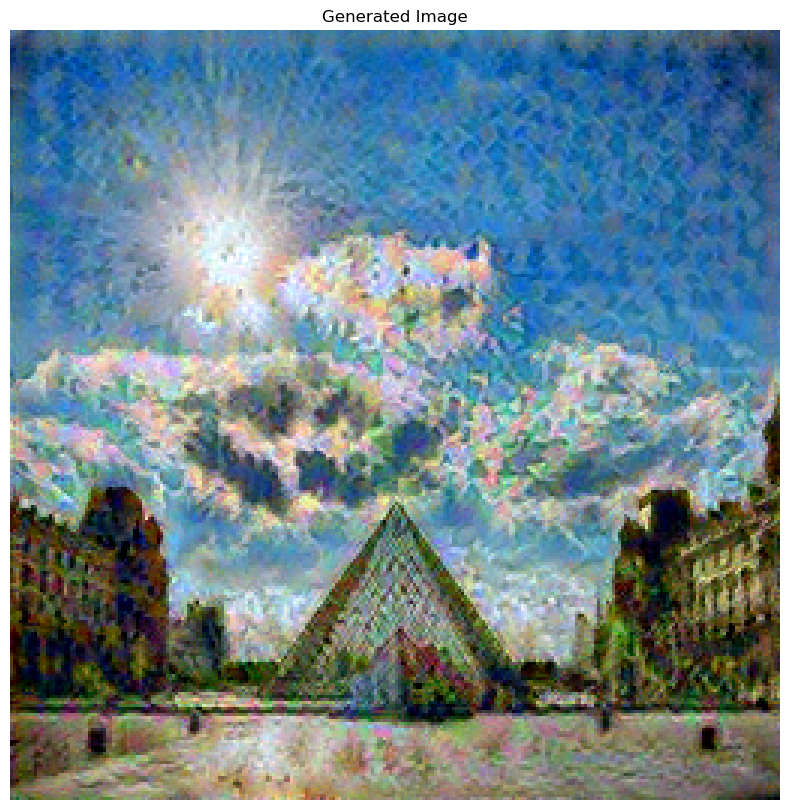

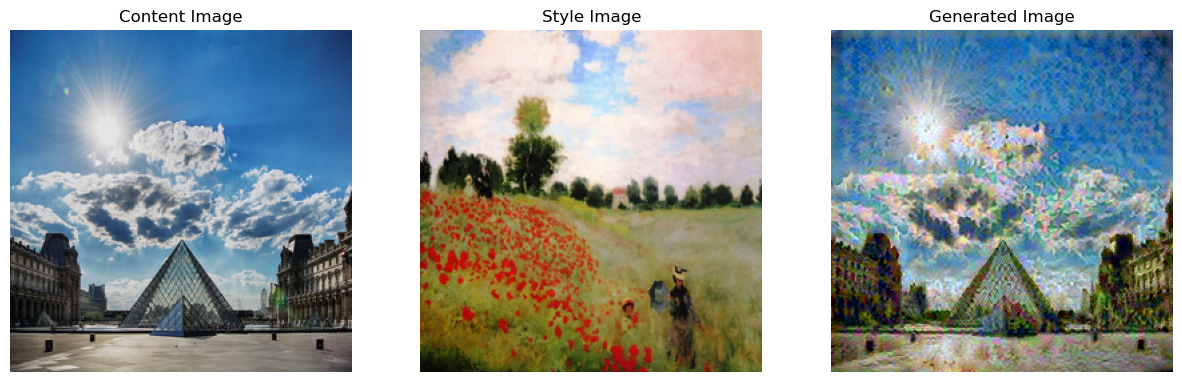


Thank you for using Neural Style Transfer!


In [8]:
def main():
    """Main function"""
    print("\nWelcome to Neural Style Transfer!")
    
    # Check for GPU
    if tf.test.gpu_device_name():
        print("\nGPU found: ", tf.test.gpu_device_name())
        print("Estimated processing time: 5-10 minutes")
    else:
        print("\nNo GPU found. Running on CPU.")
        print("Estimated processing time: 20-40 minutes")
    
    while True:
        # Get user inputs
        params = get_user_input()
        
        # Confirm selections
        print("\nYour selections:")
        print(f"Content Image: {params['content_path']}")
        print(f"Style Image: {params['style_path']}")
        print(f"Image Size: {params['size']}x{params['size']}")
        print(f"Output File: {params['output_path']}")
        
        confirm = input("\nProceed with these settings? (y/n): ").lower()
        if confirm == 'y':
            break
        print("\nLet's try again...")
    
    try:
        # Run style transfer
        print("\nStarting style transfer...")
        generated_image = perform_style_transfer(
            params['content_path'], 
            params['style_path'],
            target_size=(params['size'], params['size'])
        )
        
        # Save and display result
        final_image = Image.fromarray(deprocess_image(generated_image.numpy()))
        final_image.save(params['output_path'])
        print(f"\nStyle transfer complete! Result saved as: {params['output_path']}")
        
        # Display the final image
        plt.figure(figsize=(10, 10))
        plt.imshow(final_image)
        plt.axis('off')
        plt.title('Generated Image')
        plt.show()
        
        # Display side by side comparison
        plt.figure(figsize=(15, 5))
        
        # Content image
        plt.subplot(1, 3, 1)
        content_img = Image.open(params['content_path'])
        content_img = content_img.resize((params['size'], params['size']))
        plt.imshow(content_img)
        plt.title('Content Image')
        plt.axis('off')
        
        # Style image
        plt.subplot(1, 3, 2)
        style_img = Image.open(params['style_path'])
        style_img = style_img.resize((params['size'], params['size']))
        plt.imshow(style_img)
        plt.title('Style Image')
        plt.axis('off')
        
        # Generated image
        plt.subplot(1, 3, 3)
        plt.imshow(final_image)
        plt.title('Generated Image')
        plt.axis('off')
        
        plt.show()
        
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        print("Please try again with different parameters.")
    
    finally:
        print("\nThank you for using Neural Style Transfer!")

if __name__ == "__main__":
    main()